In [6]:
## Basic stuff
%load_ext autoreload
%autoreload
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))

################################################################################
## Music Stuff
################################################################################
from mp3id import mp3ID
from musicBase import musicBase
from musicFinder import musicFinder
from musicPath import pathBasics


################################################################################
## General Stuff
################################################################################
from timeUtils import clock, elapsed
from listUtils import getFlatList
from time import sleep
from pandas import DataFrame, Series
from ioUtils import getFile, saveFile
from searchUtils import findDirs, findNearest, findAll
from fileUtils import getDirBasics, getBaseFilename
from unicodedata import normalize
from fsUtils import moveDir, setDir, mkDir, isDir, removeDir
from pandasUtils import getRowDataByColValue, getRowData
from difflib import SequenceMatcher
import operator
from glob import glob
from os.path import join
from collections import Counter


################################################################################
## Database Stuff
################################################################################
from discogsBase import discogs
from multiArtist import multiartist
from masterdb import getArtistAlbumsDB, discConv


################################################################################
## Music Stuff
################################################################################
from musicUtils import *
from myMusicDBMap import myMusicDBMap
from matchAlbums import matchAlbums
from discogsBase import discogs


################################################################################
## Pandas Stuff
################################################################################
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


################################################################################
## Pandas Stuff
################################################################################
import sys
print("Python: {0}".format(sys.version))


################################################################################
## Prints
################################################################################
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Python: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Notebook Last Run Initiated: 2020-04-12 14:14:26.213928


In [2]:
mdb = myMusicDBMap(debug=True)
#mdb.getFullDBData()()

Creating myMusicDBMap()
/Users/tgadfort/Documents/code/music
   Loading my music db map: /anaconda3/envs/py37/musicdb/myMusicMap.p
   DB keys: ['Discogs', 'AllMusic', 'MusicBrainz', 'AceBootlegs', 'RateYourMusic', 'LastFM', 'DatPiff', 'RockCorner', 'CDandLP', 'MusicStack', 'MetalStorm']
Counter({'Discogs': 3897, 'AllMusic': 3796, 'MusicBrainz': 3652, 'LastFM': 2771, 'DatPiff': 439, 'RockCorner': 315, 'AceBootlegs': 163, 'CDandLP': 66, 'RateYourMusic': 25, 'MusicStack': 5, 'MetalStorm': 0})


In [3]:
def getArtistUnMatchedAlbums():
    retval         = {}
    
    
    ######################################################################
    #### Loop Over Prime Directories
    ######################################################################
    for primeDir in getPrimeDirectories():
        artistPrimeDirMap = getArtistPrimeDirMap(primeDir)
        print("UnMatched Albums: {0}".format(primeDir))
        #if primeDir.startswith("B"):
        #    break
        

        ######################################################################
        #### Loop Over Artist Name <-> Prime Map Items
        ######################################################################
        for artistName, artistPrimeDirs in artistPrimeDirMap.items():
            retval[artistName] = {"MyAlbums": [], "Todo": [], "Unknown": [], "Random": [], "Volumes": artistPrimeDirs}
            myAlbums           = {}
            for dirval in artistPrimeDirs:
                myAlbums["MyAlbums"] = getMyMusicAlbums(dirval, returnNames=True)
                myAlbums["Todo"]     = getMyTodoMusicAlbums(dirval)
                myAlbums["Unknown"]  = getMyUnknownMusicAlbums(dirval)
                myAlbums["Random"]   = getMyRandomMusic(dirval)
                
                for key in myAlbums.keys():
                    retval[artistName][key] += myAlbums[key]
            
            for key in retval[artistName].keys():
                retval[artistName][key] = len(retval[artistName][key])
            
            
    return retval
                
                    

def getArtistMatchedAlbums():
    albumTypes     = getAlbumTypes(keys=True)
    retval         = {}


    ######################################################################
    #### Loop Over Prime Directories
    ######################################################################
    for primeDir in getPrimeDirectories():
        artistPrimeDirMap = getArtistPrimeDirMap(primeDir) 
        print("Matched Albums: {0}".format(primeDir))
        #if primeDir.startswith("B"):
        #    break


        

        ######################################################################
        #### Loop Over Artist Name <-> Prime Map Items
        ######################################################################
        for artistName, artistPrimeDirs in artistPrimeDirMap.items():

            
            ######################################################################
            #### Get My Albums
            ######################################################################
            albumTypeResults = {}
            artistMatchDirs = [setDir(artistPrimeDir, 'Match', forceExist=False) for artistPrimeDir in artistPrimeDirs if isDir(artistPrimeDir, 'Match')]
            for albumType in albumTypes:
                albumTypeResults[albumType] = []
                for db in mdb.getDBs():
                    albumDBTypeNames = getAlbumTypes(db, albumType)
                    for albumDBTypeName in albumDBTypeNames:
                        for artistMatchDir in artistMatchDirs:
                            albumDBTypeDir = setDir(artistMatchDir, albumDBTypeName, forceExist=False)
                            if isDir(albumDBTypeDir):
                                #print(albumDBTypeDir)
                                albumTypeResults[albumType] += [getDirBasics(x)[-1] for x in findDirs(albumDBTypeDir)]
                                #print(len(albumTypeResults),'\t',albumTypeResults)
                albumTypeResults[albumType] = len(list(set(albumTypeResults[albumType])))
            retval[artistName] = albumTypeResults
            
            
    return retval

In [8]:
def analyzeArtistAlbums():
    
    start, cmt = clock("Analyzing Artist Albums")

    artistUnMatchedAlbums = getArtistUnMatchedAlbums()
    artistMatchedAlbums   = getArtistMatchedAlbums()    

    artistAlbumAnalysis   = {}
    artistNames = set(list(artistUnMatchedAlbums.keys()) + list(artistMatchedAlbums.keys()))
    for artistName in sorted(artistNames):
        artistMatchedAlbumResults   = artistMatchedAlbums.get(artistName)
        artistUnMatchedAlbumResults = artistUnMatchedAlbums.get(artistName)
        #print(artistName,'\t',artistMatchedAlbumResults,'\t',artistUnMatchedAlbumResults)
        
        artistAlbumAnalysis[artistName]          = artistUnMatchedAlbumResults
        artistAlbumAnalysis[artistName]["Match"] = artistMatchedAlbumResults

    return artistAlbumAnalysis

In [9]:
artistMetadata = analyzeArtistAlbums()

Current Time is Sun Apr 12, 2020 14:23:47 for Analyzing Artist Albums
UnMatched Albums: A
UnMatched Albums: B
UnMatched Albums: C
UnMatched Albums: D
UnMatched Albums: E
UnMatched Albums: F
UnMatched Albums: G
UnMatched Albums: H
UnMatched Albums: I
UnMatched Albums: J
UnMatched Albums: K
UnMatched Albums: L
UnMatched Albums: M
UnMatched Albums: N
UnMatched Albums: Num
UnMatched Albums: O
UnMatched Albums: P
UnMatched Albums: Q
UnMatched Albums: R
UnMatched Albums: S
UnMatched Albums: T
UnMatched Albums: The
UnMatched Albums: U
UnMatched Albums: V
UnMatched Albums: W
UnMatched Albums: X
UnMatched Albums: Xtra
UnMatched Albums: Y
UnMatched Albums: Z
Matched Albums: A
Matched Albums: B
Matched Albums: C
Matched Albums: D
Matched Albums: E
Matched Albums: F
Matched Albums: G
Matched Albums: H
Matched Albums: I
Matched Albums: J
Matched Albums: K
Matched Albums: L
Matched Albums: M
Matched Albums: N
Matched Albums: Num
Matched Albums: O
Matched Albums: P
Matched Albums: Q
Matched Albums: R

In [10]:
def showAlbums(vals):
    retval = "".join(["{0: <4}".format(x) for x in vals])
    return retval

minMyAlbums   = 2
minTodoAlbums = 5
import json
downloadCut   = 5

ranks = {"Matches": Counter(), "Albums": Counter()}

print("{0: <35}| {1: <10}| {2: <16}| {3: <10}| {4: <10}| {5: <10}| {6: <10}| {7: <12}| {8: <12}|".format("Artist", "Volumes", "Matches", "# Albums", "Todo", "Unknown", "Random", "No Match", "Many Albums"))
print("{0: <35}| {1: <10}| {2: <16}| {3: <10}| {4: <10}| {5: <10}| {6: <10}| {7: <12}| {8: <12}|".format("------", "-------", "-------", "--------", "----", "-------", "------", "--------", "-----------"))
      

for artistName, artistData in artistMetadata.items():
    ### Artist Name
    print("{0: <35}".format(artistName), end="")
    
    ### Volumes
    volumeData = artistData["Volumes"]
    print("| {0: <10}".format(volumeData), end="")
    
    ### Matches
    dbData = artistData["Match"]
    print("| {0: <16}".format(showAlbums(dbData.values())), end="")
    
    ### Unmatched Albums
    myAlbumsData = artistData["MyAlbums"]
    print("| {0: <10}".format(myAlbumsData), end="")
    
    ### Todo Albums
    myTodoData = artistData["Todo"]
    print("| {0: <10}".format(myTodoData), end="")
    
    ### Unknown Albums
    myUnknownData = artistData["Unknown"]
    print("| {0: <10}".format(myUnknownData), end="")
    
    ### Random Albums
    myRandomData = artistData["Random"]
    print("| {0: <10}".format(myRandomData), end="")

    ### Check For No Match
    noMatchData = sum(dbData.values())
    noMatchText = "{0}..".format(artistName[:9])
    if noMatchData > 0:
        noMatchText = ""
    print("| {0: <12}".format(noMatchText), end="")

    ### Check For Many Albums
    manyAlbumsData = myAlbumsData
    manyAlbumsText = "{0}..".format(artistName[:9])
    if manyAlbumsData < 3:
        manyAlbumsText = ""
    print("| {0: <12}".format(manyAlbumsText), end="")
        
    ### Return
    print("|")
    
    ### Ranks
    ranks["Matches"][artistName] = sum(dbData.values())
    ranks["Albums"][artistName]  = myAlbumsData

    
    continue
    
    ### Check If We Need To Download More
    #maxDB = max([len(v) for k, v in artistData["DB"].items()])
    #if maxDB > 0:
    #    totalAlbums   = sum([v for k,v in artistData["Volumes"].items()])
    #    downloadRatio = int(round(100*(totalAlbums/maxDB),0))
    #else:
    downloadRatio = "---"
    print("| {0: <10}".format(downloadRatio), end="")
    
    download = ""
    if isinstance(downloadRatio, int):
        if downloadRatio < downloadCut and maxDB > 50:
                 download = artistName
    print("| {0: <20}".format(download), end="")
    


    ### Return
    print("")

Artist                             | Volumes   | Matches         | # Albums  | Todo      | Unknown   | Random    | No Match    | Many Albums |
------                             | -------   | -------         | --------  | ----      | -------   | ------    | --------    | ----------- |
"Weird Al" Yankovic                | 1         | 13  0   0   0   | 0         | 1         | 0         | 0         |             |             |
'68 Comeback                       | 1         | 1   1   0   0   | 0         | 0         | 0         | 0         |             |             |
'68 Comeback Special               | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
*NSYNC                             | 1         | 1   1   0   0   | 2         | 2         | 0         | 2         |             |             |
-123 min.                          | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Adele                              | 1         | 3   1   12  0   | 0         | 0         | 0         | 4         |             |             |
Adryan Russ                        | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Adryan Ru.. |             |
Aerosmith                          | 1         | 9   1   1   0   | 0         | 0         | 0         | 13        |             |             |
Aetherian                          | 1         | 0   0   0   0   | 4         | 0         | 0         | 0         | Aetherian.. | Aetherian.. |
Afrodite                           | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Afrodite..  |             |
Agent 99                           | 1         | 0   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Agnostic Front                     | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Anvil                              | 1         | 13  2   0   0   | 0         | 1         | 0         | 0         |             |             |
Aphex Twin                         | 1         | 1   0   0   0   | 0         | 2         | 0         | 1         |             |             |
Apoptygma Berzerk                  | 1         | 3   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Apothys                            | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Apothys..   |             |
April Wine                         | 1         | 7   0   0   0   | 20        | 0         | 0         | 0         |             | April Win.. |
Aqua                               | 1         | 5   3   10  0   | 1         | 0         | 0         | 8         |             |             |
Arcade Fire                        | 2         | 4   0   6   0   | 2         | 0         | 2         | 3         |             |             |

Babylon Whores                     | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Babylonian Tiles                   | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Bachman-Turner Overdrive           | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Bachman-T.. |             |
Backfire!                          | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Backstreet Boys                    | 1         | 6   1   1   0   | 0         | 3         | 1         | 1         |             |             |
Bad Company                        | 1         | 1   0   0   0   | 2         | 1         | 0         | 1         |             |             |
Bad Manners                        | 1         | 3   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Big Brother & The Holding Company  | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Big Country                        | 1         | 1   1   0   0   | 0         | 0         | 0         | 1         |             |             |
Big D And The Kids Table           | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Big Electric Cat                   | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Big Head Todd                      | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Big Head Todd And The Monsters     | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Big Hello                          | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Blue Öyster Cult                   | 2         | 2   0   0   0   | 0         | 1         | 0         | 1         |             |             |
Bluebird                           | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Bluegrass Etc.                     | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Blueline Medic                     | 1         | 1   0   1   0   | 0         | 0         | 0         | 0         |             |             |
Blues Saraceno                     | 1         | 3   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Blues Traveler                     | 1         | 11  1   0   0   | 0         | 0         | 0         | 3         |             |             |
Bluetile Lounge                    | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Cap'n Jazz                         | 1         | 0   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Capital 2                          | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Capital 2.. |             |
Capitalist Casualties              | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Carcass                            | 1         | 4   0   0   0   | 0         | 1         | 0         | 0         |             |             |
Carl Orff                          | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Carl Palmer                        | 1         | 0   0   0   0   | 2         | 0         | 0         | 0         | Carl Palm.. |             |
Carla Olson                        | 1         | 0   0   1   0   | 0         | 0         | 0         | 0         |             |             |

Chris Mills                        | 1         | 3   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Chris Murray                       | 1         | 3   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Chris Rea                          | 2         | 0   0   0   0   | 2         | 2         | 0         | 0         | Chris Rea.. |             |
Christ                             | 1         | 0   0   1   0   | 0         | 1         | 0         | 0         |             |             |
Christ On A Crutch                 | 1         | 1   2   0   0   | 0         | 0         | 0         | 0         |             |             |
Christian Death                    | 1         | 8   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Christian Marclay                  | 1         | 0   1   0   0   | 0         | 0         | 0         | 0         |             |             |

Cosmic Gate                        | 2         | 4   0   0   0   | 3         | 1         | 15        | 9         |             | Cosmic Ga.. |
Cosmic Psychos                     | 1         | 3   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Countdowns                         | 1         | 1   0   0   0   | 0         | 1         | 0         | 0         |             |             |
Counting Crows                     | 2         | 1   1   0   0   | 0         | 1         | 0         | 4         |             |             |
Country Joe McDonald               | 1         | 2   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Country Johnny Mathis              | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Country J.. |             |
Covenant                           | 1         | 2   0   2   0   | 0         | 1         | 0         | 0         |             |             |

David Bowie                        | 1         | 21  6   1   2   | 8         | 12        | 0         | 21        |             | David Bow.. |
David Bromberg                     | 1         | 0   3   0   0   | 0         | 1         | 0         | 0         |             |             |
David Candy                        | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
David Cook                         | 1         | 0   0   0   0   | 1         | 2         | 0         | 2         | David Coo.. |             |
David Crow                         | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
David Gray                         | 2         | 2   2   0   0   | 2         | 0         | 0         | 2         |             |             |
David Guetta                       | 1         | 7   0   14  1   | 5         | 0         | 0         | 1         |             | David Gue.. |

Discipline                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Disclose                           | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Disclose..  |             |
Discontent                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Discordance                        | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Disembodied                        | 1         | 1   0   1   0   | 0         | 0         | 0         | 0         |             |             |
Disembowelment                     | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Disembowe.. |             |
Disgorge                           | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Elysian Fields                     | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Embalmer                           | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Emerson, Lake & Palmer             | 1         | 13  8   1   0   | 3         | 3         | 0         | 0         |             | Emerson, .. |
Emilia                             | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Emiliana Cantone                   | 1         | 9   0   0   0   | 2         | 0         | 0         | 9         |             |             |
Eminem                             | 2         | 7   0   0   0   | 2         | 0         | 3         | 2         |             |             |
Emmylou Harris                     | 1         | 20  2   1   0   | 3         | 0         | 0         | 0         |             | Emmylou H.. |

Foxy Brown                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Fracture                           | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Frampton Brothers                  | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Franciscus Henri                   | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Frank Black And The Catholics      | 1         | 5   0   0   0   | 1         | 0         | 0         | 0         |             |             |
Frank Chickens                     | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Frank Ifield                       | 1         | 0   1   0   0   | 0         | 0         | 0         | 0         |             |             |

Gary Jules                         | 1         | 0   0   0   0   | 1         | 1         | 0         | 0         | Gary Jule.. |             |
Gary Lewis                         | 1         | 1   1   0   0   | 2         | 0         | 0         | 0         |             |             |
Gary Lewis & The Playboys          | 1         | 0   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Gary Lucas                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Gary Numan                         | 1         | 1   1   0   0   | 0         | 1         | 0         | 0         |             |             |
Gas Huffer                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Gastr Del Hemp                     | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Gastr Del.. |             |

Grits                              | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Groove Armada                      | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Grotus                             | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Groundzero                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Gruntsplatter                      | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Gucci Mane                         | 1         | 10  1   0   0   | 0         | 0         | 0         | 0         |             |             |
Gudda Gudda                        | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Hellhole                           | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Hellnation                         | 1         | 2   1   0   0   | 0         | 1         | 0         | 0         |             |             |
Hellsau                            | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Helmet                             | 1         | 7   1   3   0   | 0         | 1         | 0         | 12        |             |             |
Helstar                            | 1         | 3   0   0   0   | 0         | 1         | 0         | 0         |             |             |
Hem                                | 1         | 0   0   0   0   | 0         | 0         | 0         | 0         | Hem..       |             |
Henri Landry                       | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

In Cold Blood                      | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
In Dying Days                      | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
In Extremo                         | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
In My Eyes                         | 1         | 0   1   0   0   | 0         | 0         | 0         | 0         |             |             |
In Ruins                           | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
In Strict Confidence               | 1         | 2   0   1   0   | 0         | 0         | 0         | 0         |             |             |
Inanna                             | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Jon Langford                       | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Jon Secada                         | 1         | 2   0   0   0   | 1         | 0         | 0         | 0         |             |             |
Jon Wahl And The Amadans           | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Jonell Mosser                      | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Jones Very                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Joni Mitchell                      | 1         | 19  2   0   0   | 2         | 3         | 0         | 0         |             |             |
Jonny Chan And The New Dynasty 6   | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Kyle Fischer                       | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Kylie Minogue                      | 1         | 5   0   3   0   | 3         | 1         | 0         | 1         |             | Kylie Min.. |
Kyuss                              | 1         | 0   0   1   0   | 0         | 0         | 0         | 0         |             |             |
L. Subramaniam                     | 1         | 3   0   0   0   | 0         | 0         | 0         | 0         |             |             |
L.A.P.D.                           | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
L.U.N.G.S.                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
L7                                 | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Luther Vandross                    | 1         | 1   0   0   0   | 0         | 1         | 0         | 0         |             |             |
Lux Occulta                        | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Lyle Sheraton And The Daylight Lovers| 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Lynyrd Skynyrd                     | 1         | 1   1   0   0   | 1         | 8         | 0         | 4         |             |             |
Lyres                              | 1         | 0   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Léo Ferré                          | 1         | 0   1   0   0   | 1         | 36        | 0         | 0         |             |             |
M.I.J.                             | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |            

Michel Legrand                     | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Mick Jones                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Mickey Newbury                     | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Micro Mini                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Micromars                          | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Midnight Configuration             | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Midvale                            | 1         | 0   0   0   1   | 0         | 0         | 0         | 0         |             |             |

New Terror Class                   | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
New Vintage                        | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
New York Dolls                     | 1         | 1   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Newlydeads                         | 1         | 1   0   0   0   | 0         | 1         | 0         | 0         |             |             |
Nice Device                        | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Nichelle Nichols                   | 1         | 1   0   0   0   | 1         | 0         | 0         | 0         |             |             |
Nick Cannon                        | 1         | 0   0   1   0   | 0         | 0         | 0         | 0         |             |             |

Oppressor                          | 1         | 3   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Option 30                          | 1         | 0   0   0   0   | 0         | 0         | 0         | 0         | Option 30.. |             |
Orange Cake Mix                    | 1         | 1   0   1   0   | 0         | 0         | 0         | 0         |             |             |
Orangetree                         | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Orchestral Manoeuvres in the Dark  | 1         | 10  5   0   0   | 6         | 0         | 0         | 0         |             | Orchestra.. |
Oresund Space Collective           | 1         | 33  0   0   0   | 3         | 0         | 1         | 0         |             | Oresund S.. |
Orgy                               | 1         | 1   0   0   0   | 0         | 1         | 0         | 0         |             |             |

Popgun                             | 1         | 0   0   1   0   | 0         | 0         | 0         | 0         |             |             |
Porcupine Defense                  | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Porn                               | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Porn Orchard                       | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Porter Wagoner And Dolly Parton    | 1         | 0   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Post Malone                        | 2         | 3   0   0   0   | 4         | 0         | 0         | 0         |             | Post Malo.. |
Poster Children                    | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Rice                               | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Rich O'Brien                       | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Richard Greene                     | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Richard Jeni                       | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Richard Marx                       | 1         | 11  0   0   0   | 0         | 1         | 0         | 0         |             |             |
Richard Rodgers                    | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Richard Youngs                     | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Selena Gomez & The Scene           | 1         | 0   0   2   0   | 0         | 0         | 0         | 0         |             |             |
Semisonic                          | 1         | 2   0   0   0   | 0         | 1         | 0         | 0         |             |             |
Sepultura                          | 1         | 3   1   0   0   | 2         | 0         | 0         | 0         |             |             |
Sergio Vega                        | 1         | 0   0   1   0   | 0         | 0         | 0         | 0         |             |             |
Servotron                          | 1         | 3   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Seth                               | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Setherial                          | 1         | 3   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Special Skank                      | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Species Being                      | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Specimen                           | 1         | 0   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Speculum Fight                     | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Speedball Baby                     | 1         | 1   0   1   0   | 0         | 0         | 0         | 0         |             |             |
Spencer Davis Group                | 1         | 0   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Spice Girls                        | 1         | 1   0   11  2   | 19        | 15        | 5         | 1         |             | Spice Gir.. |

Teddy Pendergrass                  | 1         | 1   3   0   0   | 0         | 0         | 0         | 0         |             |             |
Tee And Thee Crumpets              | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Tee Stunna                         | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Tee Stunn.. |             |
Teengenerate                       | 1         | 1   0   1   0   | 0         | 0         | 0         | 0         |             |             |
Telegraph                          | 1         | 2   0   1   0   | 0         | 0         | 0         | 0         |             |             |
Telephone Man                      | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Telephone.. |             |
Television Overdose                | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

The Diplomats Of Solid Sound       | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Dirtbombs                      | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Dirtmitts                      | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Dirtys                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Doobie Brothers                | 1         | 12  6   0   0   | 0         | 2         | 0         | 2         |             |             |
The Doors                          | 1         | 13  8   2   0   | 9         | 6         | 1         | 0         |             | The Doors.. |
The Double U                       | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

The Lofty Pillars                  | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Long Ryders                    | 1         | 2   0   0   0   | 1         | 0         | 0         | 0         |             |             |
The Lookyloos                      | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | The Looky.. |             |
The Lords Of Altamont              | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Lou Gramm Band                 | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Loved                          | 1         | 0   0   1   0   | 0         | 0         | 0         | 0         |             |             |
The Lumineers                      | 1         | 1   0   0   0   | 0         | 3         | 0         | 0         |             |             |

The Soil Bleeds Black              | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Souvenirs                      | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Spaceshits                     | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Spiny Anteaters                | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Splash Four                    | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Stand                          | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
The Standard                       | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

Toothpaste 2000                    | 1         | 3   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Tori Amos                          | 1         | 4   0   1   0   | 0         | 12        | 0         | 0         |             |             |
Torn Apart                         | 1         | 1   0   1   0   | 0         | 0         | 0         | 0         |             |             |
Tory Lanez                         | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Total                              | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Totally Travis                     | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Toto                               | 1         | 16  6   0   0   | 2         | 3         | 0         | 0         |             |             |

Vinnie Smith                       | 1         | 0   0   0   0   | 1         | 0         | 0         | 0         | Vinnie Sm.. |             |
Vintersorg                         | 1         | 3   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Vinyl Devotion                     | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Vio-Lence                          | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Violent Femmes                     | 1         | 3   1   0   0   | 0         | 0         | 0         | 0         |             |             |
Violent Society                    | 1         | 2   0   0   0   | 0         | 0         | 0         | 0         |             |             |
Virgil Shaw                        | 1         | 1   0   0   0   | 0         | 0         | 0         | 0         |             |             |

In [9]:
mdb.getArtistData("April Wine")

{}

In [ ]:
toget = []
for item in reversed(ranks["Matches"].most_common()):
    if item[1] == 0:
        toget.append(item[0])
toget
#saveFile(idata=toget, ifile="getRYM.p")

In [18]:
[(k,v) for k,v in ranks["Albums"].most_common() if k.startswith("S")]

[('Santana', 20),
 ('Spice Girls', 19),
 ('Sirenia', 14),
 ('Snoopy', 14),
 ('Superstar Jay', 12),
 ('Seal', 9),
 ('Shania Twain', 8),
 ('Steve Miller Band', 6),
 ('Soul Coughing', 5),
 ('System Of A Down', 5),
 ('Systems In Blue', 5),
 ('Shocking Blue', 4),
 ('Staind', 4),
 ('Selena Gomez', 3),
 ('Squeaky Burger', 3),
 ('Stereophonics', 3),
 ('Stone Temple Pilots', 3),
 ('Sublime', 3),
 ('Savage Garden', 2),
 ('Sean Paul', 2),
 ('Secret Garden', 2),
 ('Sepultura', 2),
 ('Shirley Bassey', 2),
 ('Sia', 2),
 ('Simon & Garfunkel', 2),
 ('Slim K', 2),
 ('Social Distortion', 2),
 ("Southern Style Dj's", 2),
 ('St. Vincent', 2),
 ('Steely Dan', 2),
 ('Steve Earle', 2),
 ('Stevie Ray Vaughan', 2),
 ('Stevie Wonder', 2),
 ('Sam Bush', 1),
 ('Sam Smith', 1),
 ('San Agustin', 1),
 ('Sandoz', 1),
 ('Santana Brothers', 1),
 ('Sara Bareilles', 1),
 ('Sarah McLachlan', 1),
 ('Scott Meldrum', 1),
 ('Sharks Keep Moving', 1),
 ('Shawn Colvin', 1),
 ('Sheryl Crow', 1),
 ('Shiner', 1),
 ('Shop Boyz', 1),

In [23]:
from random import random, randint

In [68]:
central = [randint(5, 20) for x in range(100)]

In [69]:
upper = [x+randint(0,7) for x in central]

In [70]:
lower = [x-randint(0,7) for x in central]

In [71]:
df = DataFrame([central, upper, lower]).T
df.columns = ["Central", "Upper", "Lower"]
from pandas import date_range
df.index = date_range("2020-01-01", periods=len(central))

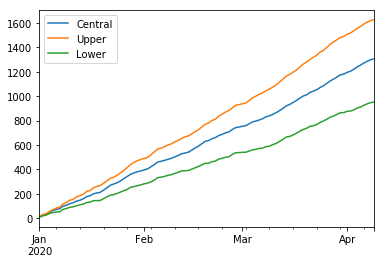

In [73]:
df.cumsum().plot()

df.to_csv("dummy.csv")

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10',
               ...
               '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-26'], dtype='datetime64[ns]', length=1000, freq='D')

In [48]:
date_range

<function pandas.core.indexes.datetimes.date_range(start=None, end=None, periods=None, freq=None, tz=None, normalize=False, name=None, closed=None, **kwargs)>